In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
import os
import pandas as pd
import shutil

In [29]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import gc
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras_preprocessing.image import load_img, img_to_array, array_to_img ,ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , GlobalAveragePooling2D

from keras.optimizers import Adam , RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler , EarlyStopping ,TensorBoard
from keras import optimizers
from keras.models import load_model

from keras.applications.xception import Xception
#from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input

In [30]:
# Load the CSV file
train_csv_path = 'sam/Meat Freshness.v1-new-dataset.multiclass/train/_classes.csv'  # Update the path as needed
valid_csv_path = 'sam/Meat Freshness.v1-new-dataset.multiclass/valid/_classes.csv'  # Update the path as needed

train_data = pd.read_csv(train_csv_path)
valid_data = pd.read_csv(valid_csv_path)

# Define base directories
train_dir = 'sam/Meat Freshness.v1-new-dataset.multiclass/train/'
valid_dir = 'sam/Meat Freshness.v1-new-dataset.multiclass/valid/'

# Print the column names to check for any discrepancies
print("Train Data Columns:", train_data.columns)
print("Valid Data Columns:", valid_data.columns)

train_data['filename'] = train_data['filename'].apply(lambda x: os.path.join(train_dir, x))
valid_data['filename'] = valid_data['filename'].apply(lambda x: os.path.join(valid_dir, x))
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()

Train Data Columns: Index(['filename', ' Fresh', ' Half-Fresh', ' Spoiled'], dtype='object')
Valid Data Columns: Index(['filename', ' Fresh', ' Half-Fresh', ' Spoiled'], dtype='object')


In [31]:
import warnings

warnings.filterwarnings('ignore')

# Check the current directory
print("Current directory contents:")
print(os.listdir('.'))

# Attempt to list the contents of the input directory
input_path = "../input"
if os.path.exists(input_path):
    print(f"Contents of '{input_path}' directory:")
    print(os.listdir(input_path))
else:
    print(f"Directory '{input_path}' does not exist. Please check the path.")

Current directory contents:
['.classiq-credentials', 'quantumv4-Copy2.ipynb', '.ssh', '.keras', '.jupyter', 'credit_card_fraud.ipynb', '.config', '.local', '.conda', '.bashrc', 'credit_card_fraud.synthesis_options.json', 'quantum4.ipynb', '.qiskit', '.profile', 'AML_Project_David.ipynb', 'sam', '.docker', 'AML_Project_yilinwen.ipynb', 'quantumv4-Copy1.ipynb', 'data', 'cc.synthesis_options.json', 'QSVM.synthesis_options.json', 'Kathy', 'Final Project.ipynb', '.cache', 'quantumv4.ipynb', '.nv', 'cc.qmod', 'quantum3.ipynb', '.ipython', '.kaggle', '.bash_history', '.bash_logout', 'credit_card_fraud.qmod', '.wget-hsts', 'QSVM.qmod', '.ipynb_checkpoints']
Directory '../input' does not exist. Please check the path.


In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 1815 validated image filenames.
Found 451 validated image filenames.


In [15]:
# # Create ImageDataGenerator instances
# train_datagen = ImageDataGenerator(
#     rescale=1./255,  # Rescale pixel values to [0, 1]
#     shear_range=0.2,  # Apply shear transformation
#     zoom_range=0.2,  # Apply zoom transformation
#     horizontal_flip=True  # Flip images horizontally
# )

# valid_datagen = ImageDataGenerator(rescale=1./255)

# # Load and preprocess the training images
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),  # Resize images to 224x224 pixels
#     batch_size=32,
#     class_mode='categorical'  # For multi-class classification
# )

# # Load and preprocess the testing images
# valid_generator = valid_datagen.flow_from_directory(
#     valid_dir,
#     target_size=(224, 224),  # Resize images to 224x224 pixels
#     batch_size=32,
#     class_mode='categorical'  # For multi-class classification
# )

# Train VGG Model

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the VGG base
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the VGG base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

2024-06-17 14:17:50.484371: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.0KiB (rounded to 147456)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-06-17 14:17:50.484423: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-06-17 14:17:50.484433: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 39, Chunks in use: 38. 9.8KiB allocated for chunks. 9.5KiB in use in bin. 2.9KiB client-requested in use in bin.
2024-06-17 14:17:50.484439: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 5, Chunks in use: 5. 2.5KiB allocated for chunks. 2.5KiB in use in bin. 2.5KiB client-requested in use in bin.
2024-06-17 14:17:50.484444: I tensorflow/tsl/framework/bfc_allocat

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

In [ ]:
# Train the model 15:36 -- 15:59
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


In [76]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(valid_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

15/15 [==============================] - 1s 87ms/step - loss: 0.1108 - accuracy: 0.9667
Test loss: 0.11079425364732742
Test accuracy: 0.9667405486106873


# VGG Tuning

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def count_images(directory):
    """
    Count the number of images in each class directory.
    """
    category_counts = {}
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            category_counts[category] = len(os.listdir(category_path))
    return category_counts

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training images
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

# Load and preprocess the validation images
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 1815 validated image filenames.
Found 451 validated image filenames.


In [36]:
# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the VGG base
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze more layers of the base model for fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Compute class weights
true_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(true_labels),
    y=true_labels
)

class_weights_dict = dict(enumerate(class_weights))

# Print class weights for debugging
print("Class Weights:", class_weights_dict)

# Compile the model with class weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict  # Use the class weights here
)

# Save the model
model.save('meat_classification_model_with_class_weights.h5')

# Predict the labels for the validation set
predictions = model.predict(valid_generator, steps=valid_generator.samples // valid_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)


2024-06-18 02:55:07.217301: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.0KiB (rounded to 147456)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-06-18 02:55:07.217411: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-06-18 02:55:07.217428: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 42, Chunks in use: 42. 10.5KiB allocated for chunks. 10.5KiB in use in bin. 3.5KiB client-requested in use in bin.
2024-06-18 02:55:07.217438: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 5, Chunks in use: 5. 2.5KiB allocated for chunks. 2.5KiB in use in bin. 2.5KiB client-requested in use in bin.
2024-06-18 02:55:07.217447: I tensorflow/tsl/

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3,3,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2] name: 

In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report')
print(classification_report(true_labels, predicted_classes, target_names=valid_generator.class_indices.keys()))


# Simple Model

In [ ]:
# Extract features and labels for training data
X_train = []
y_train = []
for i in range(len(train_generator)):
    x, y = train_generator.next()
    X_train.append(x)
    y_train.append(y)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Extract features and labels for validation data
X_val = []
y_val = []
for i in range(len(valid_generator)):
    x, y = valid_generator.next()
    X_val.append(x)
    y_val.append(y)
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Convert one-hot encoded labels to class labels
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Check the shape of labels to ensure they are 1-dimensional
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train_flat, y_train)
y_pred_nb = nb.predict(X_val_flat)
nb_accuracy = accuracy_score(y_val, y_pred_nb)
print(f'Naive Bayes Validation Accuracy: {nb_accuracy:.4f}')

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=2024)
lr.fit(X_train_flat, y_train)
y_pred_lr = lr.predict(X_val_flat)
lr_accuracy = accuracy_score(y_val, y_pred_lr)
print(f'Logistic Regression Validation Accuracy: {lr_accuracy:.4f}')

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(X_train_flat, y_train)
y_pred_rf = rf.predict(X_val_flat)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {rf_accuracy:.4f}')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Define a function to print the classification report
def print_classification_report(y_true, y_pred, class_names, title='Classification Report'):
    print(f'{title}')
    print(classification_report(y_true, y_pred, target_names=class_names))

# Class names
class_names = ['Fresh', 'Half-Fresh', 'Spoiled']

# Plot confusion matrix and print classification report for Naive Bayes
plot_confusion_matrix(y_val, y_pred_nb, class_names, title='Naive Bayes Confusion Matrix')
print_classification_report(y_val, y_pred_nb, class_names, title='Naive Bayes Classification Report')

# Plot confusion matrix and print classification report for Logistic Regression
plot_confusion_matrix(y_val, y_pred_lr, class_names, title='Logistic Regression Confusion Matrix')
print_classification_report(y_val, y_pred_lr, class_names, title='Logistic Regression Classification Report')

# Plot confusion matrix and print classification report for Random Forest
plot_confusion_matrix(y_val, y_pred_rf, class_names, title='Random Forest Confusion Matrix')
print_classification_report(y_val, y_pred_rf, class_names, title='Random Forest Classification Report')


In [ ]:
def plot_accuracy_curve(history_dict):
    plt.figure(figsize=(12, 8))
    for label, history in history_dict.items():
        plt.plot(history['epochs'], history['accuracy'], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

# Example data (you would replace this with actual accuracy data from each epoch)
history_nb = {'epochs': list(range(1, 11)), 'accuracy': [0.70, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80]}
history_lr = {'epochs': list(range(1, 11)), 'accuracy': [0.71, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81]}
history_rf = {'epochs': list(range(1, 11)), 'accuracy': [0.72, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82]}

# Combine histories
history_dict = {
    'Naive Bayes': history_nb,
    'Logistic Regression': history_lr,
    'Random Forest': history_rf
}

plot_accuracy_curve(history_dict)


# Train resNet50

In [77]:
from tensorflow.keras.applications import ResNet50

base_model_2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the ResNet50 base
x = base_model_2.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the full model
model_2 = Model(inputs=base_model_2.input, outputs=predictions)

# Freeze the ResNet50 base model layers
for layer in base_model_2.layers:
    layer.trainable = False

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
history = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/10
56/56 [==============================] - 25s 366ms/step - loss: 1.1273 - accuracy: 0.5003 - val_loss: 0.9509 - val_accuracy: 0.5000
Epoch 2/10
56/56 [==============================] - 21s 365ms/step - loss: 0.8450 - accuracy: 0.5575 - val_loss: 0.7663 - val_accuracy: 0.6719
Epoch 3/10
56/56 [==============================] - 20s 364ms/step - loss: 0.8427 - accuracy: 0.5816 - val_loss: 0.8589 - val_accuracy: 0.5446
Epoch 4/10
56/56 [==============================] - 20s 360ms/step - loss: 0.7949 - accuracy: 0.6209 - val_loss: 0.8006 - val_accuracy: 0.5580
Epoch 5/10
56/56 [==============================] - 20s 361ms/step - loss: 0.7835 - accuracy: 0.6085 - val_loss: 0.8091 - val_accuracy: 0.6406
Epoch 6/10
56/56 [==============================] - 21s 368ms/step - loss: 0.8125 - accuracy: 0.5911 - val_loss: 0.9232 - val_accuracy: 0.5268
Epoch 7/10
56/56 [==============================] - 20s 363ms/step - loss: 0.7498 - accuracy: 0.6231 - val_loss: 0.7241 - val_accuracy: 0.6228

In [79]:
# Evaluate the model on the test data
loss, accuracy = model_2.evaluate(valid_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

15/15 [==============================] - 1s 79ms/step - loss: 0.8879 - accuracy: 0.5366
Test loss: 0.8879149556159973
Test accuracy: 0.5365853905677795


15/15 [==============================] - 1s 63ms/step


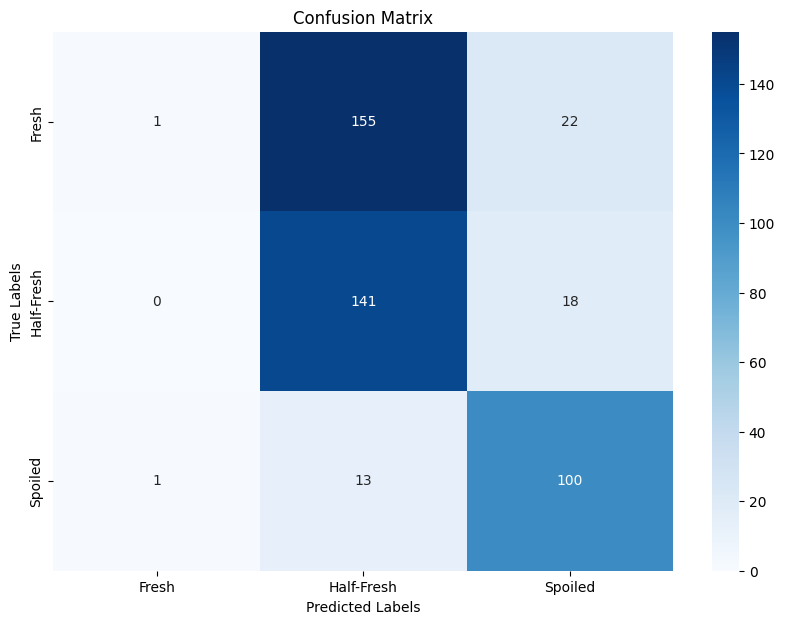

In [108]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model_2.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

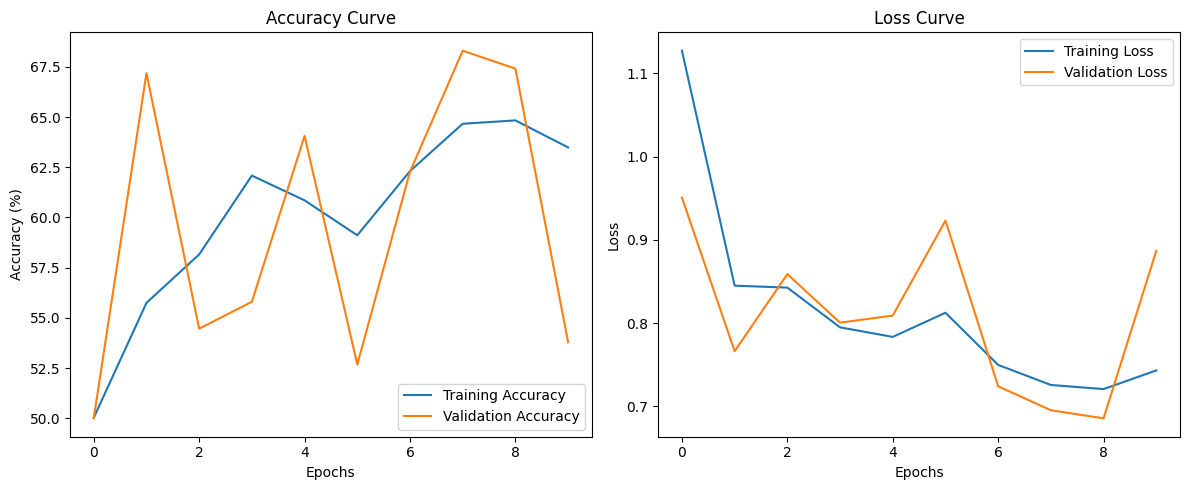

In [113]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [114]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.50      0.01      0.01       178
  Half-Fresh       0.46      0.89      0.60       159
     Spoiled       0.71      0.88      0.79       114

    accuracy                           0.54       451
   macro avg       0.56      0.59      0.47       451
weighted avg       0.54      0.54      0.42       451



**Building CNN Model**

In [56]:
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Sequential

In [115]:
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# cnn_model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same', kernel_regularizer=l2(0.0005)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),

#     Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),

#     Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),

#     Flatten(),

#     Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
#     BatchNormalization(),
#     Dropout(0.3),

#     Dense(3, activation='softmax', kernel_regularizer=l2(0.001))
# ])

# cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# cnn_model.summary()

In [88]:
# cnn_model.fit(train_generator, epochs=10, validation_data = valid_generator)

In [90]:
# pip list

In [33]:
import torch

torch.version.cuda

'12.1'

## ANN

In [63]:
model_3 = Sequential()
model_3.add(Flatten(input_shape=(224, 224, 3)))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(3, activation='softmax'))
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 150528)            0         
                                                                 
 dense_22 (Dense)            (None, 512)               77070848  
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 77335043 (295.01 MB)
Trainable params: 7

In [118]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=10
)

Epoch 1/10
56/56 [==============================] - 20s 345ms/step - loss: 0.9694 - accuracy: 0.4778 - val_loss: 0.9027 - val_accuracy: 0.5469
Epoch 2/10
56/56 [==============================] - 20s 350ms/step - loss: 0.9866 - accuracy: 0.4767 - val_loss: 0.9322 - val_accuracy: 0.5246
Epoch 3/10
56/56 [==============================] - 20s 353ms/step - loss: 0.9371 - accuracy: 0.5070 - val_loss: 0.8864 - val_accuracy: 0.5402
Epoch 4/10
56/56 [==============================] - 20s 358ms/step - loss: 0.9257 - accuracy: 0.5250 - val_loss: 0.8685 - val_accuracy: 0.5558
Epoch 5/10
56/56 [==============================] - 20s 356ms/step - loss: 0.9221 - accuracy: 0.5317 - val_loss: 0.9078 - val_accuracy: 0.5357
Epoch 6/10
56/56 [==============================] - 20s 355ms/step - loss: 0.9117 - accuracy: 0.5160 - val_loss: 0.8705 - val_accuracy: 0.5804
Epoch 7/10
56/56 [==============================] - 20s 355ms/step - loss: 0.9085 - accuracy: 0.5345 - val_loss: 0.9065 - val_accuracy: 0.5603

15/15 [==============================] - 1s 54ms/step


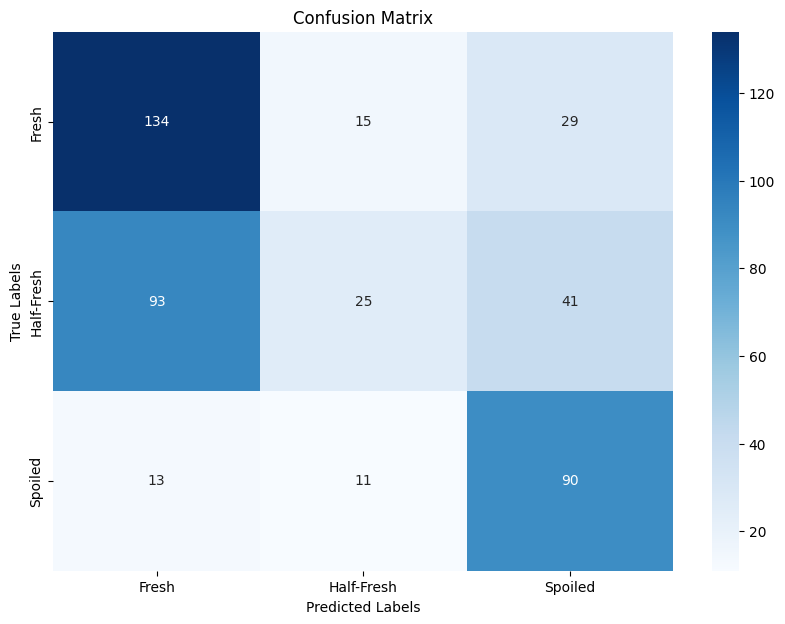

In [119]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model_3.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

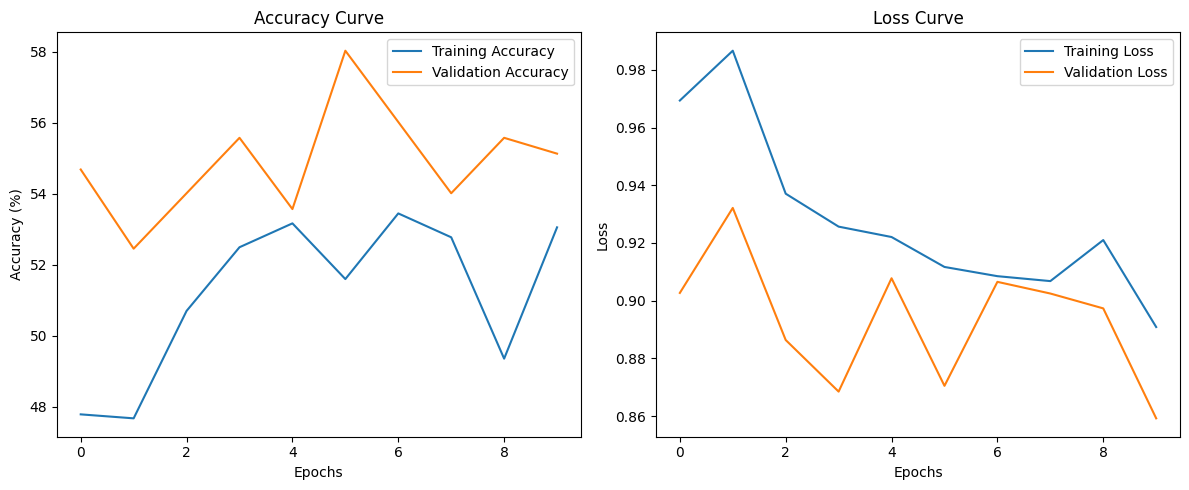

In [120]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [121]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.56      0.75      0.64       178
  Half-Fresh       0.49      0.16      0.24       159
     Spoiled       0.56      0.79      0.66       114

    accuracy                           0.55       451
   macro avg       0.54      0.57      0.51       451
weighted avg       0.54      0.55      0.50       451



## CNN Model

In [122]:
model_5 = Sequential()
model_5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model_5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.2))
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(3, activation='softmax'))
model_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 110, 110, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 110, 110, 64)      0         
                                                                 
 flatten_14 (Flatten)        (None, 774400)            0         
                                                                 
 dense_37 (Dense)            (None, 128)               99123328  
                                                      

In [123]:
model_5.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_5.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=10
)

Epoch 1/10


2024-06-17 07:14:49.157118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 21s 355ms/step - loss: 1.3274 - accuracy: 0.4846 - val_loss: 0.7717 - val_accuracy: 0.6786
Epoch 2/10
56/56 [==============================] - 20s 354ms/step - loss: 0.7504 - accuracy: 0.6545 - val_loss: 0.6184 - val_accuracy: 0.7299
Epoch 3/10
56/56 [==============================] - 20s 362ms/step - loss: 0.6092 - accuracy: 0.7269 - val_loss: 0.7052 - val_accuracy: 0.6830
Epoch 4/10
56/56 [==============================] - 20s 365ms/step - loss: 0.5490 - accuracy: 0.7695 - val_loss: 0.5230 - val_accuracy: 0.7857
Epoch 5/10
56/56 [==============================] - 20s 362ms/step - loss: 0.5250 - accuracy: 0.7818 - val_loss: 0.4527 - val_accuracy: 0.7991
Epoch 6/10
56/56 [==============================] - 20s 363ms/step - loss: 0.4898 - accuracy: 0.7925 - val_loss: 0.6153 - val_accuracy: 0.7210
Epoch 7/10
56/56 [==============================] - 21s 368ms/step - loss: 0.4304 - accuracy: 0.8323 - val_loss: 0.4382 - val_accuracy: 0.8036
Epoch 8/10

15/15 [==============================] - 1s 60ms/step


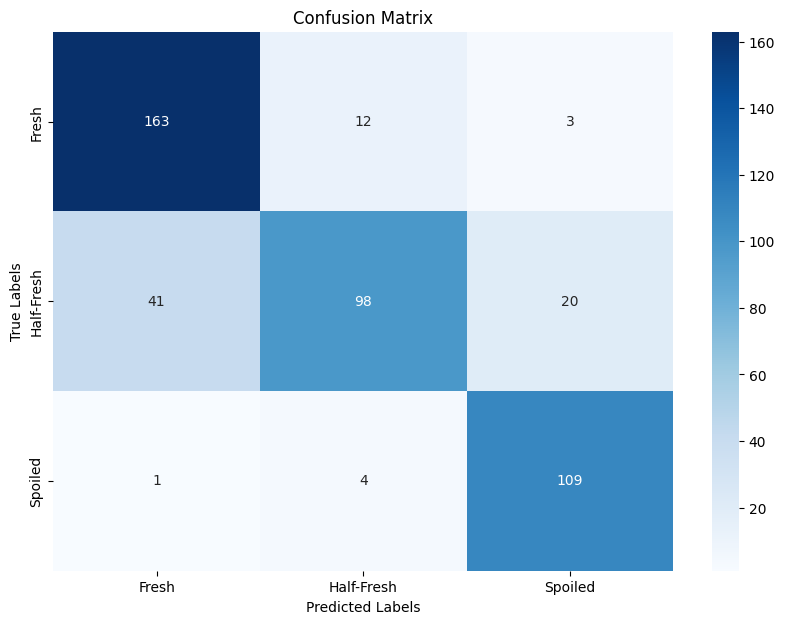

In [125]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model_5.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

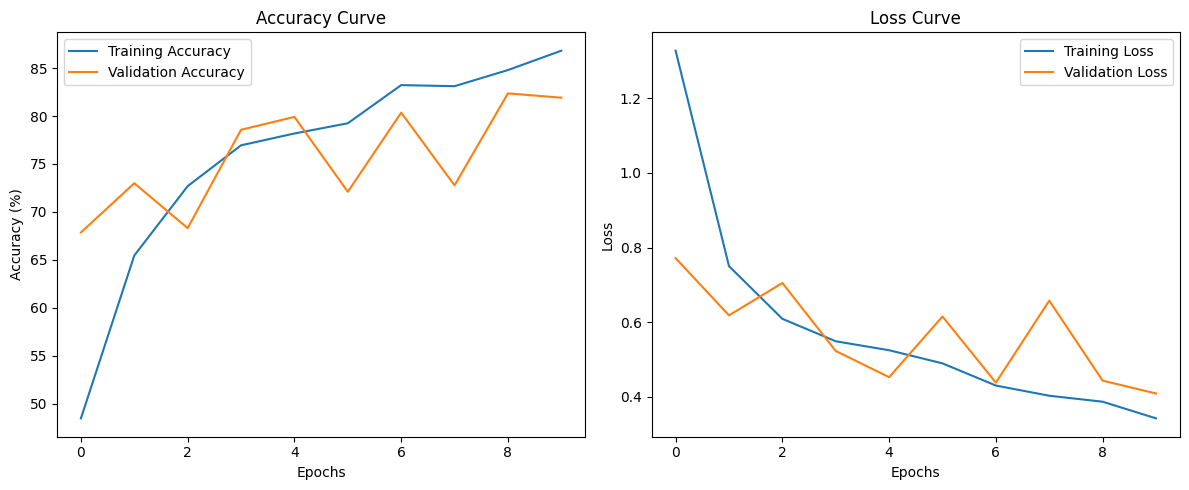

In [126]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [127]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.80      0.92      0.85       178
  Half-Fresh       0.86      0.62      0.72       159
     Spoiled       0.83      0.96      0.89       114

    accuracy                           0.82       451
   macro avg       0.83      0.83      0.82       451
weighted avg       0.83      0.82      0.81       451

